In [1]:
import pandas as pd
import numpy as np
import json
import requests
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
API_KEY = os.getenv('API_KEY')

In [3]:
def pages_to_json(page,desired_year):    
    url = 'https://api.data.gov/ed/collegescorecard/v1/schools.json'
    response = requests.get(url,
                            params={'fields':'id,{year}.student,{year}.cost,{year}.aid,{year}.completion,{year}.admission,{year}.academics'.format(year=desired_year),
                                    'keys_nested':'true',
                                    'page':page,
                                    'api_key':API_KEY}
                           )
    print('data:',response.text)
    res = response.json()
    data = res['results']
    
    # write raw results to_files
    json_object = json.dumps(data, indent=4)
    
    with open("../data/raw/page_{}_{}.json".format(desired_year,str(page)), "w") as outfile:
        outfile.write(json_object)

        
def schools_to_json(page):
    url = 'https://api.data.gov/ed/collegescorecard/v1/schools.json'
    response = requests.get(url,
                            params={'fields':'id,school',
                                    'keys_nested':'true',
                                    'page':page,
                                    'api_key':API_KEY}
                           )
    res = response.json()
    print('school:',response.text)
    data = res['results']
    
    json_object = json.dumps(data, indent=4)
    
    with open("../data/raw/schools_page_{}.json".format(str(page)), "w") as outfile:
        outfile.write(json_object)

def data_to_df(desired_year):
    # Removing 'program_available' key, which returns true of false
    # Depending on whether 'program' has a non-zero value
    # 2 indicates program available distance edu only
    
    pages = os.listdir('../data/raw')
    data_pages = [page for page in pages
                  if '_{year}_'.format(year=desired_year) in page] 
    schools_pages = [page for page in pages
                     if 'schools_' in page]
    
    df_infos = []
    for data_page in data_pages:
        with open('../data/raw/' + data_page) as json_file:
            data = json.load(json_file)

        for datum in data:
            datum['{year}'.format(year=desired_year)]['academics'].pop('program_reporter', None)
            datum['{year}'.format(year=desired_year)]['academics'].pop('program_available', None)
            datum['{year}'.format(year=desired_year)]['cost'].pop('program_reporter', None)

        df = pd.json_normalize(data)
        df_dropping = df.copy()

        # zero fills and dropping writing
        completion_columns = [feat for feat in df_dropping.columns if '{year}.completion'.format(year=desired_year) in feat]
        zero_repl = dict(zip(completion_columns, np.zeros_like(completion_columns,dtype='int')))
        df_dropping = df_dropping.fillna(zero_repl)

        writing_columns = [feat for feat in df_dropping.columns if 'writing' in feat]
        df_dropping = df_dropping.drop(columns=writing_columns)

        share_columns = [feat for feat in df_dropping.columns if '{year}.student'.format(year=desired_year) in feat]
        zero_repl = dict(zip(share_columns, np.zeros_like(share_columns,dtype='int')))
        df_dropping = df_dropping.fillna(zero_repl)

        program_pct_avail = [feat for feat in df_dropping.columns if 'latest.academics.program' in feat]
        zero_repl = dict(zip(program_pct_avail, np.zeros_like(program_pct_avail,dtype='int')))
        df_dropping = df_dropping.fillna(zero_repl)

        # enrollment.all is discontinued
        df_dropping = df_dropping.drop(columns='{year}.student.enrollment.all'.format(year=desired_year))

        # don't need this column
        df_dropping = df_dropping.drop(columns='latest.admissions.admission_rate.by_ope_id')

        # handle behaviors
        public_columns = [
            feat for feat in df_dropping.columns 
            if '{year}.cost.avg_net_price.public'.format(year=desired_year) in feat
            or '{year}.cost.net_price.public'.format(year=desired_year) in feat
            or '{year}.cost.title_iv.public'.format(year=desired_year) in feat
        ]
        private_columns = [
            feat for feat in df_dropping.columns 
            if '{year}.cost.avg_net_price.private'.format(year=desired_year) in feat
            or '{year}.cost.net_price.private'.format(year=desired_year) in feat
            or '{year}.cost.title_iv.private'.format(year=desired_year) in feat
        ]
        program_columns = [
            feat for feat in df_dropping.columns 
            if '{year}.cost.avg_net_price.program_year'.format(year=desired_year) in feat
            or '{year}.cost.net_price.program_reporter'.format(year=desired_year) in feat
            or '{year}.cost.title_iv.program_reporter'.format(year=desired_year) in feat
            or '{year}.cost.title_iv.program_year'.format(year=desired_year) in feat
        ]
        other_ay_columns = [
            feat for feat in df_dropping.columns 
            if '{year}.cost.avg_net_price.other_academic_year'.format(year=desired_year) in feat
            or '{year}.cost.net_price.other_acad_calendar'.format(year=desired_year) in feat
            or '{year}.cost.title_iv.other_acad_calendar'.format(year=desired_year) in feat
            or '{year}.cost.title_iv.academic_year'.format(year=desired_year) in feat
        ]
        public_net_columns = [
            feat for feat in df_dropping.columns 
            if 'latest.cost.avg_net_price.public' in feat
            or 'latest.cost.net_price.public' in feat
        ]
        consumer_columns = [
            feat for feat in df_dropping.columns 
            if 'latest.cost.avg_net_price.overall' in feat
            or 'latest.cost.net_price.consumer' in feat
        ]
        for i in range(len(public_columns)):
            df_dropping[public_columns[i]].fillna(df_dropping[private_columns[i]],inplace=True)
            df_dropping[public_columns[i]].fillna(df_dropping[program_columns[i]],inplace=True)
            df_dropping[public_columns[i]].fillna(df_dropping[other_ay_columns[i]],inplace=True)
        df_dropping = df_dropping.drop(columns=private_columns)
        df_dropping = df_dropping.drop(columns=program_columns)
        df_dropping = df_dropping.drop(columns=other_ay_columns)

        for i in range(len(public_net_columns)):
            df_dropping[public_net_columns[i]].fillna(df_dropping[consumer_columns[i]],inplace=True)
        df_dropping = df_dropping.drop(columns=consumer_columns)

        df_dropping['latest.cost.avg_net_price.consumer.median_by_pred_degree'].fillna(
            df_dropping['latest.cost.avg_net_price.consumer.overall_median'],inplace=True)

        df_dropping.columns = df_dropping.columns.str.replace(r'latest.cost.avg_net_price.public',
                                                          'latest.cost.avg_net_price',
                                                          regex=True)
        df_dropping.columns = df_dropping.columns.str.replace(r'latest.cost.net_price.public',
                                                          'latest.cost.net_price',
                                                          regex=True)
        df_dropping.columns = df_dropping.columns.str.replace(r'latest.cost.title_iv.public',
                                                          'latest.cost.title_iv',
                                                          regex=True)

        df_dropping['{year}.cost.attendance.academic_year'.format(year=desired_year)].fillna(
            df_dropping['{year}.cost.attendance.program_year'.format(year=desired_year)],
            inplace=True)
        df_dropping['{year}.cost.tuition.in_state'.format(year=desired_year)].fillna(
            df_dropping['{year}.cost.tuition.program_year'.format(year=desired_year)],
            inplace=True)
        df_dropping['{year}.cost.tuition.out_of_state'.format(year=desired_year)].fillna(
            df_dropping['{year}.cost.tuition.program_year'.format(year=desired_year)],
            inplace=True)
        df_dropping = df_dropping.drop(columns=['{year}.cost.attendance.program_year'.format(year=desired_year), 
                                                '{year}.cost.tuition.program_year'.format(year=desired_year)])

        df_renaming = df_dropping.copy()
        df_renaming.columns = df_renaming.columns.str.replace(r'{year}.'.format(year=desired_year),'',regex=True)
        df_renaming.columns = df_renaming.columns.str.replace(r'.','_',regex=True)
        df_info = df_renaming.copy()
        df_infos.append(df_info)

    schools_dfs = []
    for schools_page in schools_pages:
        with open('../data/raw/' + schools_page) as json_file:
            school = json.load(json_file)
        
        df_school_data = pd.json_normalize(school)
        df_school_data.columns = df_school_data.columns.str.replace(r'school.','',regex=True)
        df_school_data.columns = df_school_data.columns.str.replace(r'.','_',regex=True)
        df_school_data_drops = df_school_data.drop(columns=['zip','url','price_calculator_url',
                                                            'search','accreditor','alias','degree_urbanization',
                                                            'degrees_awarded_predominant_recoded'])

        df_school_data_drops = df_school_data_drops.fillna({'religious_affiliation':-1,
                                                            'carnegie_undergrad':-1,
                                                            'accreditor_code':'NONE',
                                                            'locale':1})

        columns_to_zero = [feat for feat in df_school_data_drops.columns
                           if 'carnegie_basic' in feat
                           or 'carnegie_size_setting' in feat
                           or 'open_admissions_policy' in feat
                           or 'minority_serving' in feat
                           or '_only' in feat
                           or 'endowment_' in feat
                           or 'ownership_peps' in feat]
        zero_repl = dict(zip(columns_to_zero, np.zeros_like(columns_to_zero,dtype='int')))
        df_school_data_drops = df_school_data_drops.fillna(zero_repl)
        schools_df = df_school_data_drops.copy()
        schools_dfs.append(schools_df)
        
    info = pd.concat(df_infos)    
    schools = pd.concat(schools_dfs)
    df = schools.merge(info,on='id')
    return df

In [4]:
# The data contains information for 6681, results are sent in pages of 20 items
(6681 // 20) + 1

335

Add years as desired below. Commented out as files are already saved for most recent data.

In [5]:
# years = ['latest']
# for year in years:
#     for i in range(335):
#         pages_to_json(i,year)
#         schools_to_json(i,year)

In [6]:
# Commented out code since only using most recent for now
# dfs = []
# for year in years:
#     dfs.append(data_to_df(year))
# df = pd.concat(dfs)
df = data_to_df('latest')

In [7]:
df.shape

(6681, 1968)

In [8]:
df.to_csv('../data/interim/fix_dtypes.csv')

In [9]:
# df = pd.read_csv('../data/interim/fix_dtypes.csv')

This pipeline handles some of the quircky aspects of this nested data structure. Some of these columns may be `None` across the board. Some columns referring to shares of students population or completion demographics may be `0` across the board. These will be the first columns to drops.

155


<AxesSubplot:>

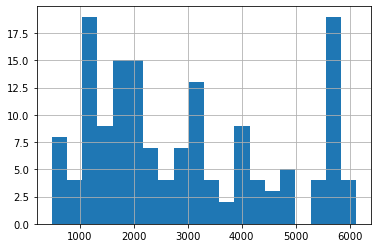

In [10]:
print(len(df.isna().sum()[df.isna().sum() > 0]))
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).hist(bins=20)

In [11]:
df.dtypes.value_counts()

float64    1647
object      158
int64        89
int32        74
dtype: int64

In [12]:
df = df.convert_dtypes()
df.dtypes.value_counts()

Float64    1269
Int64       619
Int32        74
string        5
object        1
dtype: int64

In [13]:
df.select_dtypes(include=['object','string'])

,name,city,state,accreditor_code,title_iv_approval_date,completion_separation_date_median
0,Alabama A & M University,Normal,AL,SACSCC,12/12/1965,12/31/2999
1,University of Alabama at Birmingham,Birmingham,AL,SACSCC,12/1/1965,12/31/2999
2,Amridge University,Montgomery,AL,SACSCC,3/26/1987,08/05/2016
3,University of Alabama in Huntsville,Huntsville,AL,SACSCC,12/1/1965,12/31/2999
4,Alabama State University,Montgomery,AL,SACSCC,12/1/1965,12/31/2999
...,...,...,...,...,...,...
6676,Raritan Valley Community College,Branchburg,NJ,MSACHE,12/20/1968,09/15/2016
6677,Stevens Institute of Technology,Hoboken,NJ,MSACHE,12/1/1965,12/31/2999
6678,Stockton University,Galloway,NJ,MSACHE,12/1/1969,12/31/2999
6679,Talmudical Academy-New Jersey,Adelphia,NJ,AARTS,1/30/1975,0


`completion_separation_date_median` is discontinued... drop it

In [14]:
df = df.drop(columns='completion_separation_date_median')

In [15]:
# approval date to datetime_object
df['title_iv_approval_date'] = pd.to_datetime(df['title_iv_approval_date'],format="%m/%d/%Y")
df['title_iv_approval_date']

0      1965-12-12
1      1965-12-01
2      1987-03-26
3      1965-12-01
4      1965-12-01
          ...    
6676   1968-12-20
6677   1965-12-01
6678   1969-12-01
6679   1975-01-30
6680   1967-03-03
Name: title_iv_approval_date, Length: 6681, dtype: datetime64[ns]

In [16]:
df.dtypes.value_counts()

Float64           1269
Int64              619
Int32               74
string               4
datetime64[ns]       1
dtype: int64

As a result of the order with which I filled some `None` values with zeroes, where a `None` indicated that no data was applicable to the field, and the field represented a proportion or percentage. However, some of these fields were discontinued. I.e. the category was indicated `None` not because truly 0% of the student body fell under that category, but rather that the feature itself was discontinued as a classifier. In other words 0% of the institution's student body have x feature because 'x' feature has been renamed 'x1' or grouped in with 'x2'. Ideally, I would have liked to have more control of the fields I selected from the API, and in future iterations should consider using Data Dictionary itself to be more precise in removing unwanted columns. For now, I will remove columns with all zeroes!

In [17]:
len(df.isna().sum()[df.isna().sum() == len(df)])

0

In [18]:
dfn = df.select_dtypes(include=['Float64','Int64','Int32'])
to_check = []
for feat in dfn.columns:
    if (dfn[feat] == 0).all():
        to_check.append(feat)
to_not_drop = [feat for feat in to_check 
               if 'died' in feat or 
               'transf_unknown' in feat or 
               'academics_program_certificate_lt_4_yr_military' in feat]
to_drop = list(set(to_check).difference(set(to_not_drop)))
df = df.drop(columns=to_drop)

In [19]:
df.shape

(6681, 1925)

In [20]:
pd.set_option('display.max_rows', 500)
df.isna().sum()[df.isna().sum() > 0]

tuition_revenue_per_fte                                          577
instructional_expenditure_per_fte                                577
faculty_salary                                                  2757
ft_faculty_rate                                                 3135
title_iv_approval_date                                           578
cost_avg_net_price                                              1288
cost_net_price_by_income_level_0-30000                          1313
cost_net_price_by_income_level_30001-48000                      1313
cost_net_price_by_income_level_48001-75000                      1898
cost_net_price_by_income_level_75001-110000                     1864
cost_net_price_by_income_level_110001-plus                      2291
cost_net_price_by_income_level_0-48000                          1302
cost_net_price_by_income_level_30001-75000                      1853
cost_net_price_by_income_level_75000-plus                       2815
cost_title_iv_all                 

Immediate takeaway... there is a lot of information missing related to SAT scores, in fact most of the information is missing. This could be a problem, but could also be really insightful if it indicates a specific point where the university stopped requiring SAT scores.
<br>Cost and aid take up a great deal of the missing values space. Need a way to to code values where data is missing because it is not relevant (i.e. universities not approved for Title IV with data missing for Title IV) 